# Mesure de l'identité cellulaire dans les données tumorales TCGA-BRCA

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns

In [2]:
data_dir = 'data/'

## Dataset d'entrainement TSG3 (total)

In [3]:
tsg_part1 = pd.read_csv(data_dir + 'TSG3_train_2386_samples_882_genes.csv', sep=';', index_col=0)
tsg_part2 = pd.read_csv(data_dir + 'TSG3_test_796_samples_1685_genes.csv', sep=';', index_col=0)
tsg_part2 = tsg_part2[tsg_part1.columns]
data_train = pd.concat([tsg_part1, tsg_part2])
data_train = data_train.sort_values(by='target', ascending=True)

In [4]:
y_train = data_train['target']
X_train = data_train.drop(columns=['target'])
colnames = [int(c.split('@')[1]) for c in X_train.columns]
X_train.columns = colnames
print(X_train.shape)
X_train.head()

(3182, 882)


,2670,6440,6439,729238,653509,4504,7038,6616,5004,3849,...,170692,10022,347732,2116,440699,100506393,287015,645426,402160,160762
id_sample,,,,,,,,,,,,,,,,,,,,,
GTEX-U8XE-0626-SM-3DB8U,2.689662,0.983745,0.743568,0.743396,0.354118,0.119908,0.485344,0.725644,0.000000,0.826595,...,0.023832,0.000000,0.194565,0.069999,0.0,3.182688,0.000000,0.013582,0.593952,0.000000
GTEX-S7SE-0526-SM-2XCD8,2.548608,0.740868,0.716842,0.491858,0.178298,1.017564,1.029501,2.157372,0.000000,1.619688,...,0.000000,0.000000,0.121476,0.201391,0.0,1.502331,0.000000,0.291164,0.037825,0.024630
GTEX-Q2AH-2026-SM-2S1PX,1.682858,0.097141,0.052708,0.066852,0.000000,0.383916,0.091831,0.684865,0.000000,1.135233,...,0.025140,0.000000,0.139576,0.097553,0.0,2.817155,0.000000,0.074833,0.050799,0.024918
GTEX-QDVN-2326-SM-2S1PF,1.200145,0.120915,0.000000,0.056150,0.000000,0.545186,0.155007,0.117337,0.101059,1.233318,...,0.000000,0.000000,0.574108,0.159729,0.0,2.464877,0.016349,0.123135,0.042629,0.000000
GTEX-QEG5-0626-SM-2S1PP,1.294459,0.000000,0.023331,0.039429,0.000000,0.738031,0.043478,0.357249,0.053797,0.187715,...,0.036570,0.059931,0.276684,0.243555,0.0,2.099524,0.008583,0.016729,0.011282,0.010970


## Dataset de test TCGA-BRCA

In [5]:
data_test = pd.read_csv(data_dir + 'expression_data_tcga_brca_TCGA-BRCA_log_fpkm_1217_samples_2095_genes.csv', sep=';')
data_test.index = data_test['id_gene'].astype('int') # data_test['gene_symbol'] + '@' + data_test['id_gene'].astype('string')
data_test = data_test.drop(columns=['id_gene', 'gene_symbol'])
data_test.head()

,TCGA-3C-AAAU-01A,TCGA-3C-AALI-01A,TCGA-3C-AALJ-01A,TCGA-3C-AALK-01A,TCGA-4H-AAAK-01A,TCGA-5L-AAT0-01A,TCGA-5T-A9QA-01A,TCGA-A1-A0SB-01A,TCGA-A1-A0SD-01A,TCGA-A1-A0SE-01A,...,TCGA-UL-AAZ6-01A,TCGA-UU-A93S-01A,TCGA-V7-A7HQ-01A,TCGA-W8-A86G-01A,TCGA-WT-AB41-01A,TCGA-WT-AB44-01A,TCGA-XX-A899-01A,TCGA-XX-A89A-01A,TCGA-Z7-A8R5-01A,TCGA-Z7-A8R6-01A
id_gene,,,,,,,,,,,,,,,,,,,,,
10,0.568351,2.191191,0.046650,0.434700,0.044057,0.562159,0.232108,0.064238,0.474661,0.453981,...,0.122138,1.306973,0.490078,0.853937,0.627816,1.714388,0.177098,4.158016,0.446890,0.164657
15,0.011320,0.455035,0.187601,0.048183,0.091551,0.037239,0.074072,0.077205,0.010564,0.100322,...,0.278962,0.119185,0.077924,0.145296,0.476969,0.043022,0.232911,0.230493,0.101733,0.023210
24,0.047757,0.514031,0.037717,0.614050,0.430184,0.802103,0.112226,0.065553,1.187533,0.227926,...,0.071573,0.101417,1.209807,0.853124,0.508641,0.489712,0.267261,0.496931,1.008124,1.214697
56,0.149501,0.130592,0.457520,0.082488,0.103169,0.125132,0.334338,0.294867,0.071671,0.020427,...,0.154639,0.295572,0.150419,0.044704,0.065642,0.063438,0.024811,0.093154,0.034373,0.357263
124,0.000000,0.000000,0.027495,0.035208,0.038763,0.018179,0.018313,0.025415,0.040559,0.039753,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.356572,0.496424,0.000000,0.011302


In [6]:
expgroup = pd.read_excel(data_dir + 'EpiMed_experimental_grouping_2022.01.31_TCGA-BRCA.xlsx')
print('The warning is raised because the filename contains dot "." caracters. Just ignore.')
expgroup = expgroup[expgroup['tissue_status']=='tumoral']
expgroup.index = expgroup['id_sample']
expgroup.head()

C:\USR\Python\Python39\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


The warning is raised because the filename contains dot "." caracters. Just ignore.


,id_sample,main_gse_number,id_platform,organism,sample_title,sample_source,sex,ethnic_group,age_min,age_max,...,pr,her2,pam50,ki67_fpkm,upa_fpkm,pai1_fpkm,os_censor,dfs_censor,3-GEC,claudin_low
id_sample,,,,,,,,,,,,,,,,,,,,,
TCGA-AO-A129-01A,TCGA-AO-A129-01A,TCGA-BRCA,multi,Homo sapiens,fe3921db-1691-432f-b7fa-703ae8d7bfd2,Primary Tumor,F,not hispanic or latino,29.86,29.86,...,negative,negative,basal-like,15.356154,42.304145,23.067746,0.0,0.0,3.0,0.0
TCGA-A8-A0AD-01A,TCGA-A8-A0AD-01A,TCGA-BRCA,multi,Homo sapiens,392933ed-ca0e-458d-b0b1-6ccfe71df1c3,Primary Tumor,F,not reported,83.31,83.31,...,positive,negative,luminal-A,2.974550,57.188708,13.310795,0.0,0.0,0.0,0.0
TCGA-AO-A1KT-01A,TCGA-AO-A1KT-01A,TCGA-BRCA,multi,Homo sapiens,15c2deaa-1162-4ee8-b698-179bfd67a78d,Primary Tumor,F,not hispanic or latino,78.52,78.52,...,positive,negative,luminal-B,5.661733,120.260433,25.734686,0.0,0.0,3.0,0.0
TCGA-C8-A26Z-01A,TCGA-C8-A26Z-01A,TCGA-BRCA,multi,Homo sapiens,5da663cd-e223-41ec-8b2f-796c141ec677,Primary Tumor,F,not hispanic or latino,NaN,NaN,...,positive,negative,luminal-A,5.444601,25.105408,21.915387,0.0,0.0,1.0,0.0
TCGA-A1-A0SM-01A,TCGA-A1-A0SM-01A,TCGA-BRCA,multi,Homo sapiens,289f5433-4834-401f-9361-efc8e883e630,Primary Tumor,M,not hispanic or latino,77.25,77.25,...,negative,positive,NaN,4.727732,82.204732,69.783814,0.0,0.0,0.0,0.0


Exclure les données normales

In [7]:
data_test = data_test[expgroup.index]

## Réduction de variables dans X_test

In [8]:
X_test = data_test.T
X_test = X_test[X_train.columns]
X_test = X_test.dropna()
print(X_test.shape)
X_test.head()

(1075, 882)


id_gene,2670,6440,6439,729238,653509,4504,7038,6616,5004,3849,...,170692,10022,347732,2116,440699,100506393,287015,645426,402160,160762
TCGA-AO-A129-01A,0.065624,0.000000,0.101944,0.018899,0.000000,0.242558,0.036247,0.307182,3.716080,0.039947,...,0.444140,0.069723,0.381069,0.239967,0.125007,0.317799,0.0,0.152088,0.006649,0.023199
TCGA-A8-A0AD-01A,0.014923,0.018966,0.007385,0.000000,0.000000,0.032757,0.095202,0.337889,0.000000,0.000000,...,0.147170,0.041946,0.457935,0.147724,0.000000,0.000000,0.0,0.122102,0.441270,0.000000
TCGA-AO-A1KT-01A,0.070577,0.000000,0.014532,0.986560,0.016236,1.288103,0.115668,1.400655,0.086205,0.007912,...,0.109591,0.000000,0.144401,0.367396,0.014543,0.000000,0.0,0.111907,0.366869,0.009133
TCGA-C8-A26Z-01A,0.086505,0.000000,0.004881,2.216294,0.071965,0.032450,0.077319,0.372504,0.000000,0.007946,...,0.029782,0.027835,0.338349,0.644427,0.000000,0.000000,0.0,0.112369,0.204976,0.009172
TCGA-A1-A0SM-01A,0.031772,0.000000,0.023590,0.560156,0.007955,0.010604,0.058510,0.368096,0.021537,0.023071,...,0.054579,0.000000,0.685783,0.394907,0.014211,0.000000,0.0,0.109436,0.154667,0.000000


## Normalisation de données

In [9]:
scaler = StandardScaler()
scaler.fit(X_train, y_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

## Prédiction

In [10]:
random_state = 0
classifier = MLPClassifier(hidden_layer_sizes=(100, 100, 100), random_state=random_state, max_iter=500)
classifier.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, random_state=0)

In [11]:
y_train_pred = classifier.predict(X_train_scaled)
y_test_pred = classifier.predict(X_test_scaled)

In [12]:
y_test = X_test.shape[0] * ['breast'] 
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print('Accuracy train (normal tissues)', '{:.3f}'.format(accuracy_train))
print('Accuracy test (tumors)', '{:.3f}'.format(accuracy_test))

Accuracy train (normal tissues) 1.000
Accuracy test (tumors) 0.907


## Erreurs

In [13]:
results = pd.DataFrame()
results['real'] = y_test
results['predicted'] = y_test_pred
results['type'] = results['real'] + ' -> ' + results['predicted']

In [14]:
errors = results[results['real']!=results['predicted']]
print(errors.shape)
errors.head()

(100, 3)


,real,predicted,type
25,breast,uterus,breast -> uterus
30,breast,prostate,breast -> prostate
31,breast,muscles,breast -> muscles
33,breast,artery,breast -> artery
47,breast,bronchus_lung,breast -> bronchus_lung


In [15]:
sample_size = errors.groupby(['type']).size().reset_index(name='size')
sample_size = sample_size.sort_values(by=['size'], ascending=False).reset_index(drop=True)
sample_size

,type,size
0,breast -> uterus,45
1,breast -> connective_tissues,12
2,breast -> muscles,8
3,breast -> prostate,8
4,breast -> thyroid_gland,7
5,breast -> esophagus,5
6,breast -> artery,4
7,breast -> colon,2
8,breast -> fibroblast,2
9,breast -> testis,2


## Probabilité

In [16]:
proba = classifier.predict_proba(X_test_scaled)
tissues = list(y_train.unique())
proba = pd.DataFrame(proba, index=X_test_scaled.index, columns=tissues)
proba.head()

,artery,blood,brain,breast,bronchus_lung,central_nervous_system,colon,connective_tissues,esophagus,fibroblast,heart,kidney,liver,muscles,prostate,skin,stomach,testis,thyroid_gland,uterus
TCGA-AO-A129-01A,2.725231e-06,1.303746e-05,2.098973e-06,0.999773,4.136887e-07,2.169524e-07,1.376437e-07,4.019022e-07,3.663951e-06,5.902167e-07,5.992009e-06,5.953277e-05,8.133122e-06,6.085573e-05,2.270353e-05,6.279903e-06,4.164349e-07,6.229928e-08,3.897858e-05,3.360654e-07
TCGA-A8-A0AD-01A,4.110454e-11,1.979270e-10,4.958005e-09,1.000000,8.255034e-10,9.971938e-11,5.229725e-13,6.288527e-12,5.427232e-09,7.376461e-12,4.327906e-10,3.623531e-08,4.034185e-08,2.349515e-09,8.807102e-08,1.110307e-10,3.229357e-10,6.648933e-11,5.689979e-08,5.915738e-10
TCGA-AO-A1KT-01A,1.417694e-05,7.535764e-06,3.071290e-04,0.971443,4.689132e-05,2.828339e-05,2.444133e-06,2.059557e-05,3.421312e-04,1.799452e-05,3.370805e-05,7.013968e-04,2.411320e-04,2.999364e-04,1.029864e-02,2.208720e-05,3.726355e-05,2.464552e-05,1.437621e-02,1.734767e-03
TCGA-C8-A26Z-01A,1.651360e-05,1.012246e-06,1.559842e-04,0.995267,1.525986e-05,2.461634e-06,2.319068e-07,1.593851e-03,4.786038e-06,3.169560e-06,1.797122e-07,7.372108e-06,6.295304e-05,7.855023e-04,2.227673e-04,9.567365e-06,1.412856e-06,1.859351e-06,1.567860e-03,2.801619e-04
TCGA-A1-A0SM-01A,2.855519e-09,4.232808e-09,3.760837e-08,0.999997,3.940635e-09,7.834002e-10,4.860885e-12,1.351170e-09,1.808403e-08,2.994515e-10,1.294094e-08,6.227806e-08,3.591245e-07,5.837890e-08,1.653353e-06,2.308542e-09,9.878561e-10,4.609948e-10,3.357140e-07,4.961947e-09


## Export des probabilités dans un fichier

In [17]:
proba = proba.sort_values(by='breast', ascending=False)
proba.index.name = 'id_sample'
filename = 'Cell_identity_probability_' + str(proba.shape[0]) + '_samples_' + str(proba.shape[1]) + '_tissues.csv'
proba.to_csv(data_dir + filename, sep=';', index=True)

## Visualisation

In [18]:
mean = proba.mean().sort_values(ascending=False)
mean.head()

breast                0.872297
uterus                0.039546
connective_tissues    0.014309
thyroid_gland         0.014109
muscles               0.013637
dtype: float64

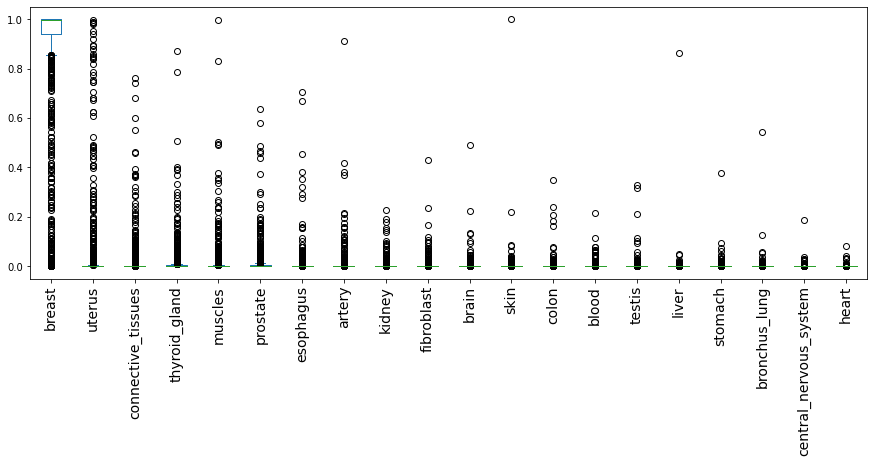

In [19]:
ax = proba[mean.index].plot.box(figsize=(15, 5))
ax.tick_params(axis='x', labelrotation=90, labelsize=14) 

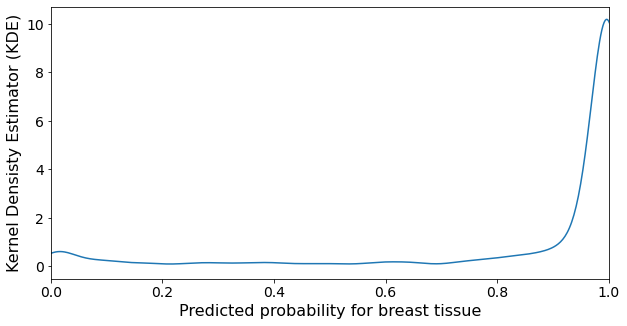

In [20]:
text_options = {'fontsize': 16}
ax = proba['breast'].plot.kde(bw_method=0.1, figsize=(10, 5))
ax.set_xlabel('Predicted probability for breast tissue', **text_options)
ax.set_ylabel('Kernel Densisty Estimator (KDE)', **text_options)
ax.tick_params(axis='both', labelsize=14)
t = ax.set_xlim([0.0, 1.0])

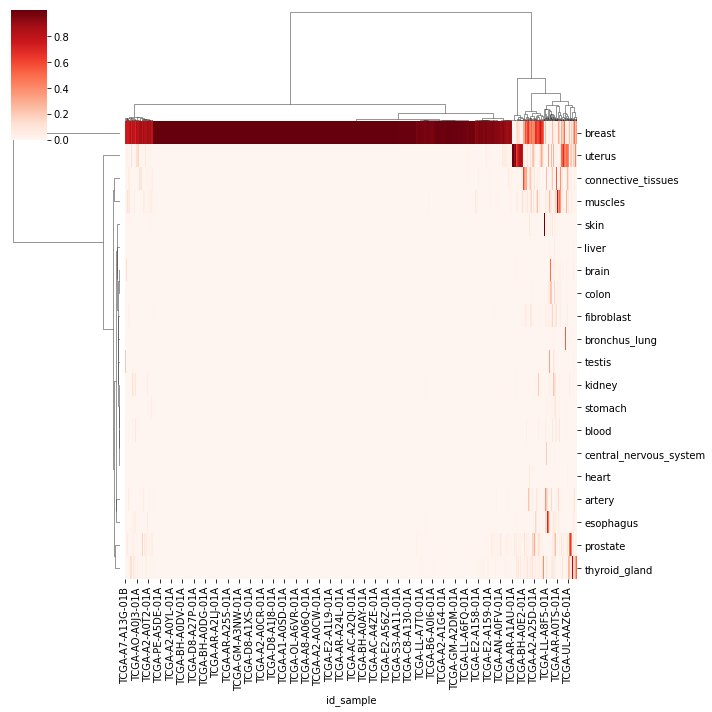

In [21]:
ax = sns.clustermap(proba.T, cmap='Reds', method='ward', center=0.5)

In [22]:
no_identity_loss = proba['breast']>0.99
identity_loss = proba['breast']<0.33
print('No identity loss:', proba[no_identity_loss].shape[0], 'samples')
print('Identity loss:', proba[identity_loss].shape[0], 'samples')

No identity loss: 668 samples
Identity loss: 98 samples
